<a href="https://colab.research.google.com/github/yanamushka/ML-course/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [2]:
pip install opendatasets


In [3]:
import opendatasets as od

In [4]:
data_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data?select=train.csv'


In [5]:
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yanamushka
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 24.7MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)
Area under ROC score on Train dataset: 0.88%


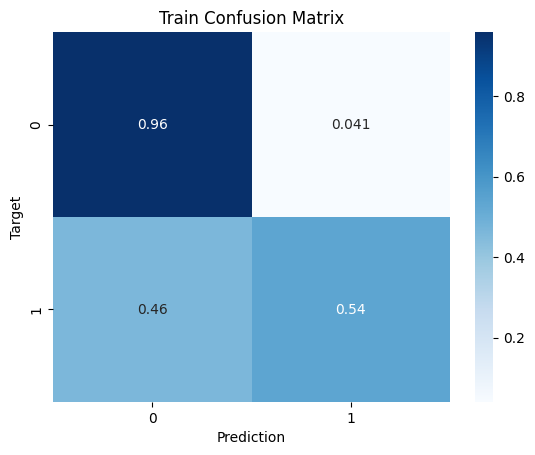

Area under ROC score on Validation dataset: 0.88%


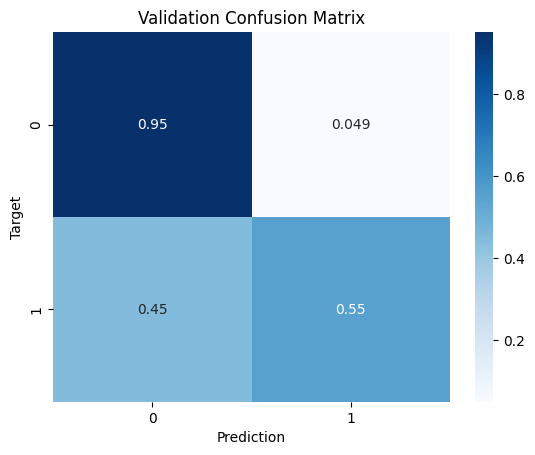

['bank_customer_pipeline']

In [6]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import joblib



data_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data?select=train.csv'
od.download(data_url)
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size = 0.25, random_state=42, stratify = raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns[3:-1])
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols],val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include = 'object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds


# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_customer_pipeline')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train polynom dataset: 0.92%


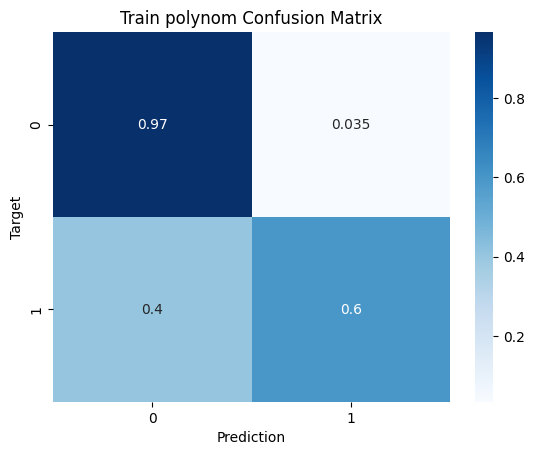

Area under ROC score on Validation polinom dataset: 0.92%


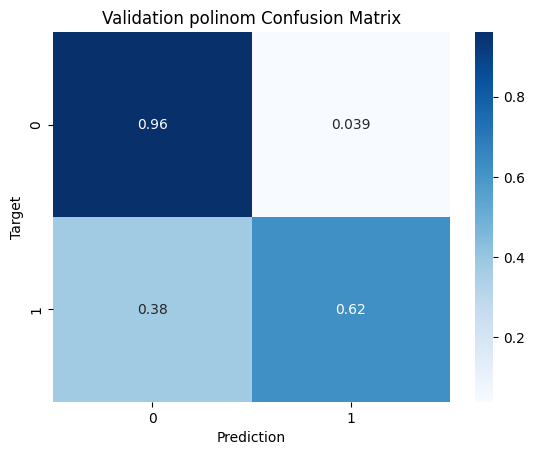

array([0., 1., 0., ..., 0., 0., 0.])

In [7]:
from sklearn.preprocessing import PolynomialFeatures

new_numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
     ('polinomial', PolynomialFeatures(degree=2))
])
new_preprocessor = ColumnTransformer(transformers = [
    ('num', new_numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

new_pipeline = Pipeline(steps = [('new_preprocessor', new_preprocessor),
                                 ('classifier', LogisticRegression())])
new_pipeline.fit(train_inputs, train_targets)
predict_and_plot(new_pipeline, train_inputs, train_targets, 'Train polynom')
predict_and_plot(new_pipeline, val_inputs, val_targets, 'Validation polinom')

Бачимо, що показники можелі покращились як для тестового так і для валідаційного набору. З даних показників немає свідчень про наявність overfit чи underfit. Модель однаково добре передбачає цільову змінну для тренувальних та валідаційних даних

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train polynom 4 dataset: 0.93%


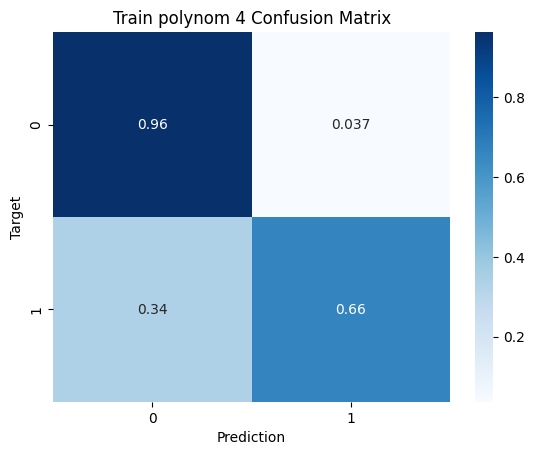

Area under ROC score on Validation polinom 4 dataset: 0.93%


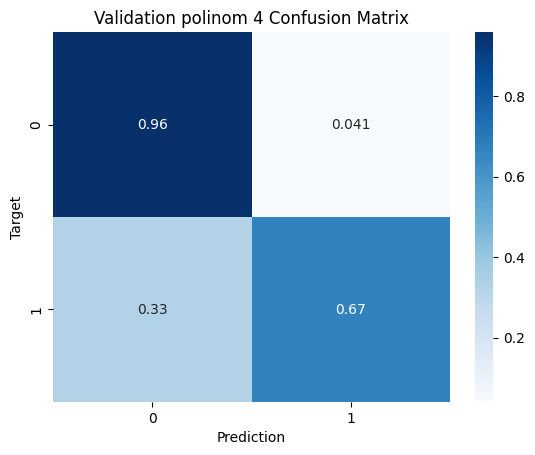

array([0., 1., 0., ..., 0., 0., 0.])

In [8]:
new_numeric_transformer_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
     ('polinomial', PolynomialFeatures(degree=4))
])
new_preprocessor_4 = ColumnTransformer(transformers = [
    ('num', new_numeric_transformer_4, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

new_pipeline_4 = Pipeline(steps = [('new_preprocessor_4', new_preprocessor_4),
                                 ('classifier', LogisticRegression(max_iter = 10000))])
new_pipeline_4.fit(train_inputs, train_targets)
predict_and_plot(new_pipeline_4, train_inputs, train_targets, 'Train polynom 4')
predict_and_plot(new_pipeline_4, val_inputs, val_targets, 'Validation polinom 4')

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df_reg_data = pd.read_csv("drive/MyDrive/regression_data.csv")
df_reg_data.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-0.082039,-0.017872,0.092293,-0.076084,0.053098,-3.902984
std,0.941214,1.065887,0.978557,0.910588,1.004498,45.466621
min,-3.241267,-2.619745,-1.913280,-2.211135,-2.301921,-111.753810
25%,-0.699726,-0.756351,-0.553649,-0.730367,-0.772825,-37.339533
50%,-0.066080,-0.161286,0.120296,0.018418,0.013002,-0.641298
75%,0.529804,0.679598,0.624120,0.519347,0.787085,25.464414
max,2.122156,3.852731,3.078881,2.314659,2.075401,115.125907


In [11]:
input_reg_data_col= list(df_reg_data.columns[:4])
target_reg_data_col= 'target'

In [12]:
df_reg_train, df_reg_test = train_test_split(df_reg_data, test_size = 0.2, random_state=42)

In [13]:
train_inputs_reg = df_reg_train[input_reg_data_col]
test_inputs_reg = df_reg_test[input_reg_data_col]
train_target_reg = df_reg_train[target_reg_data_col]
test_target_reg = df_reg_test[target_reg_data_col]

In [14]:
poly_features = PolynomialFeatures(degree=5)

input_train_poly = poly_features.fit_transform(train_inputs_reg)
input_test_poly = poly_features.fit_transform(test_inputs_reg)

poly_reg = LinearRegression()

poly_reg.fit(input_train_poly, train_target_reg)
taget_predict_train = poly_reg.predict(input_train_poly)
taget_predict_test = poly_reg.predict(input_test_poly)
rmse_train = mean_squared_error(train_target_reg, taget_predict_train, squared = False)
rmse_test = mean_squared_error(test_target_reg, taget_predict_test, squared = False)
print(f"RMSE for train data {rmse_train}")
print(f"RMSE for test data {rmse_test}")

RMSE for train data 2.7097156646291765e-13
RMSE for test data 48.70713177281642


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


З результатів бачимо, що для тренувальних даних модель має хороший результат, але для тестових значно більша помилка, що свідчить про overfitting

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [58]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Ridge(),
    Lasso(),
    Lasso(alpha = 0.01),
    ElasticNet()
]

In [50]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)

  train_metrics = mean_squared_error(y_train, y_train_pred, squared = False)
  test_metrics = mean_squared_error(y_test, y_test_pred, squared = False)
  return dict(train = train_metrics, test = test_metrics)

In [51]:
poly_features_20 = PolynomialFeatures(degree = 20)
x_train_poly_20 = poly_features_20.fit_transform(train_inputs_reg )
x_test_poly_20 = poly_features_20.fit_transform(test_inputs_reg )

In [59]:
import warnings
warnings.filterwarnings("ignore")

for model in models:
  model.fit(x_train_poly_20, train_target_reg)
  eval_result = evaluate_model(model,x_train_poly_20, train_target_reg, x_test_poly_20, test_target_reg)
  print(f'{str(model)}: {eval_result}\n')

Ridge(): {'train': 31.82024352462784, 'test': 17726.835681736004}

Lasso(): {'train': 2.187397160924509, 'test': 65.75777804291907}

Lasso(alpha=0.01): {'train': 0.5449827263726883, 'test': 5.4138792439304}

ElasticNet(): {'train': 11.19407765901291, 'test': 85.2523616537223}



Найкраще генералізує модель Лассо, але результат не можемо вважати задовільним так як для тестових даних доволі велика помилка.Проте, якщо встановити показник альфа для Лассо Регресії на рівні 0.01, то отримуємо значно кращий результат ніж отриманий для лінійнох регресії.